<a href="https://colab.research.google.com/github/dvoils/neural-network-experiments/blob/main/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST

In [5]:
# -*- coding: utf-8 -*-
# Associative Memory Testbed (MNIST) — Hopfield (binary/continuous), Modern Hopfield, Conv-AE, KNN(AE-latent)
# Author: you + GPT-5 Thinking
# ---------------------------------------------------------------

import math, random, time
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# -----------------------------
# Setup
# -----------------------------
SEED = 1337
random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# -----------------------------
# Data (MNIST 28x28)
# -----------------------------
tf = transforms.Compose([
    transforms.ToTensor(),  # [0,1]
])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=tf)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=tf)

BATCH = 256
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

IMG_SHAPE = (1, 28, 28)
DIM = 28 * 28

# -----------------------------
# Utilities: binarize, bipolar, noise, metrics
# -----------------------------
def to_flat(x: torch.Tensor) -> torch.Tensor:
    return x.view(x.shape[0], -1)

def to_img(x: torch.Tensor) -> torch.Tensor:
    return x.view(x.shape[0], *IMG_SHAPE)

def to_bipolar01(x: torch.Tensor) -> torch.Tensor:
    """ [0,1] -> {-1, +1} via threshold 0.5 """
    return torch.where(x >= 0.5, torch.ones_like(x), torch.zeros_like(x)) * 2 - 1

def from_bipolar01(x: torch.Tensor) -> torch.Tensor:
    """ {-1,+1} -> [0,1] """
    return (x + 1) / 2

@torch.no_grad()
def bitflip_noise_bipolar(x_bipolar: torch.Tensor, flip_prob: float) -> torch.Tensor:
    # x in {-1,+1}; flip with prob p
    mask = torch.rand_like(x_bipolar).le(flip_prob)
    return torch.where(mask, -x_bipolar, x_bipolar)

@torch.no_grad()
def gaussian_noise(x01: torch.Tensor, sigma: float) -> torch.Tensor:
    return torch.clamp(x01 + sigma * torch.randn_like(x01), 0.0, 1.0)

@torch.no_grad()
def salt_pepper(x01: torch.Tensor, p: float) -> torch.Tensor:
    noise = torch.rand_like(x01)
    sp = x01.clone()
    sp[noise < (p/2)] = 0.0
    sp[(noise >= (p/2)) & (noise < p)] = 1.0
    return sp

@torch.no_grad()
def occlusion(x01: torch.Tensor, frac: float) -> torch.Tensor:
    # zero out a random square patch covering ~frac of pixels
    b, c, h, w = x01.size()
    area = int(h * w * frac)
    side = max(1, int(math.sqrt(area)))
    out = x01.clone()
    for i in range(b):
        r = random.randint(0, max(0, h - side))
        c0 = random.randint(0, max(0, w - side))
        out[i, :, r:r+side, c0:c0+side] = 0.0
    return out

def psnr(mse: float, max_val: float = 1.0) -> float:
    if mse <= 1e-12:
        return 99.0
    return 10.0 * math.log10((max_val * max_val) / mse)

# -----------------------------
# Class prototypes (for simple class-accuracy after recall)
# -----------------------------
@torch.no_grad()
def compute_class_prototypes_bipolar(ds: datasets.MNIST) -> torch.Tensor:
    """Return (10, DIM) in {-1,+1} by sign(mean_per_class - 0.5)."""
    sums = torch.zeros(10, DIM)
    counts = torch.zeros(10)
    for img, y in DataLoader(ds, batch_size=512, shuffle=False):
        img = to_flat(img)
        for k in range(10):
            mask = (y == k)
            if mask.any():
                sums[k] += img[mask].sum(dim=0)
                counts[k] += mask.sum()
    means = sums / counts.unsqueeze(1)
    protos_01 = torch.where(means >= 0.5, torch.ones_like(means), torch.zeros_like(means))
    protos_bipolar = protos_01 * 2 - 1
    return protos_bipolar  # (10, DIM)

CLASS_PROTOS = compute_class_prototypes_bipolar(train_ds).to(DEVICE)

# -----------------------------
# Prepare "memories" for Hopfield models (patterns to store)
# -----------------------------
def sample_memories_from_train(n_per_class: int = 20) -> torch.Tensor:
    """Return (P, DIM) bipolar patterns, P = 10 * n_per_class."""
    idxs = []
    labels_to_get = {c: n_per_class for c in range(10)}
    for i, (_, y) in enumerate(train_ds):
        c = int(y)
        if labels_to_get[c] > 0:
            idxs.append(i)
            labels_to_get[c] -= 1
        if sum(labels_to_get.values()) == 0:
            break
    sub = Subset(train_ds, idxs)
    loader = DataLoader(sub, batch_size=len(sub), shuffle=False)
    (imgs, _labels) = next(iter(loader))
    bip = to_flat(to_bipolar01(imgs))
    return bip.to(DEVICE)

MEMORIES = sample_memories_from_train(n_per_class=20)  # shape (200, 784) bipolar

# ============================================================
# Associative Memory Base
# ============================================================
class BaseAssocMemory(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def store(self, patterns: torch.Tensor):
        """Optionally called with (P, DIM) memory patterns."""
        return self

    def recall(self, x: torch.Tensor, steps: int = 5) -> torch.Tensor:
        """Return reconstruction with same shape as input (B, DIM)."""
        raise NotImplementedError

    @property
    def expects_bipolar(self) -> bool:
        """If True, recall() expects {-1,+1} flattened inputs."""
        return True

# ============================================================
# Hopfield (Binary, synchronous)
# ============================================================
class HopfieldBinary(BaseAssocMemory):
    def __init__(self, dim: int):
        super().__init__(dim)
        self.register_buffer("W", torch.zeros(dim, dim))

    @torch.no_grad()
    def store(self, patterns: torch.Tensor):
        # patterns: (P, DIM) in {-1,+1}
        P = patterns.size(0)
        W = patterns.t() @ patterns
        # Remove self-connections
        W.fill_diagonal_(0.0)
        # Normalize (optional). Many choices exist; we use 1/P.
        self.W = W / P
        return self

    @torch.no_grad()
    def recall(self, x: torch.Tensor, steps: int = 5) -> torch.Tensor:
        # x: (B, DIM) bipolar
        out = x.clone()
        for _ in range(steps):
            out = torch.sign(out @ self.W)
            out[out == 0] = 1.0
        return out

# ============================================================
# Hopfield (Continuous, tanh)
# ============================================================
class HopfieldContinuous(BaseAssocMemory):
    def __init__(self, dim: int, beta: float = 2.0):
        super().__init__(dim)
        self.beta = beta
        self.register_buffer("W", torch.zeros(dim, dim))

    @torch.no_grad()
    def store(self, patterns: torch.Tensor):
        P = patterns.size(0)
        W = patterns.t() @ patterns
        W.fill_diagonal_(0.0)
        self.W = W / P
        return self

    @torch.no_grad()
    def recall(self, x: torch.Tensor, steps: int = 10) -> torch.Tensor:
        out = x.clone()
        for _ in range(steps):
            out = torch.tanh(self.beta * (out @ self.W))
        # Return as bipolar-ish in [-1,1]
        return torch.sign(out)  # binarize for fair comparison

# ============================================================
# Modern Hopfield (Attention-style retrieval)
# x_{t+1} = softmax(beta * M x_t^T) M  (with batch handling)
# ============================================================
class ModernHopfield(BaseAssocMemory):
    def __init__(self, dim: int, beta: float = 8.0, mix: float = 1.0):
        super().__init__(dim)
        self.beta = beta
        self.mix  = mix
        self.register_buffer("M", torch.zeros(1, dim))  # will become (P, dim)

    def store(self, patterns: torch.Tensor):
        # patterns: (P, DIM) in {-1,+1}. Normalize (optional)
        M = F.normalize(patterns, dim=1)  # stability
        self.M = M
        return self

    @torch.no_grad()
    def recall(self, x: torch.Tensor, steps: int = 5) -> torch.Tensor:
        # x: (B, DIM) bipolar
        B = x.size(0)
        M = self.M  # (P, DIM)
        out = x.clone()
        for _ in range(steps):
            logits = self.beta * (out @ M.t())      # (B, P)
            attn = torch.softmax(logits, dim=1)     # (B, P)
            retrieved = attn @ M                     # (B, DIM)
            out = self.mix * retrieved + (1 - self.mix) * out
            out = torch.sign(out)  # keep it crisp
            out[out == 0] = 1.0
        return out

# ============================================================
# Conv Autoencoder (Denoising Memory)
# ============================================================
class EncoderConv(nn.Module):
    def __init__(self, latent_dim: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 7x7
        )
        self.fc = nn.Linear(64*7*7, latent_dim)

    def forward(self, x):
        h = self.net(x)
        h = h.view(h.size(0), -1)
        z = self.fc(h)
        return z

class DecoderConv(nn.Module):
    def __init__(self, latent_dim: int = 64):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 64*7*7)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2), nn.ReLU(),  # 14x14
            nn.ConvTranspose2d(32, 16, 2, stride=2), nn.ReLU(),  # 28x28
            nn.Conv2d(16, 1, 3, padding=1), nn.Sigmoid(),
        )

    def forward(self, z):
        h = self.fc(z)
        h = h.view(h.size(0), 64, 7, 7)
        xhat = self.net(h)
        return xhat

class AutoencoderMemory(BaseAssocMemory):
    def __init__(self, encoder: nn.Module, decoder: nn.Module):
        super().__init__(dim=DIM)
        self.encoder = encoder
        self.decoder = decoder

    @property
    def expects_bipolar(self) -> bool:
        return False  # expects [0,1] images

    @torch.no_grad()
    def recall(self, x_img_flat: torch.Tensor, steps: int = 1) -> torch.Tensor:
        # Input comes as flattened [0,1]; convert to image
        x_img = to_img(x_img_flat)
        z = self.encoder(x_img)
        xr = self.decoder(z)
        xr = xr.view(x_img_flat.shape[0], -1)
        # For comparison with binary metrics, binarize a copy:
        xr_bip = to_bipolar01(xr.view(-1, 1, 28, 28)).view(xr.shape[0], -1)
        return xr_bip  # return bipolar to match other models' scoring

# ============================================================
# KNN Memory in AE Latent Space
# ============================================================
class KNNLatentMemory(BaseAssocMemory):
    def __init__(self, encoder: nn.Module, decoder: nn.Module, k: int = 3):
        super().__init__(dim=DIM)
        self.enc = encoder
        self.dec = decoder
        self.k = k
        self.register_buffer("mem_latents", torch.zeros(1, 1))
        self.register_buffer("mem_codes", torch.zeros(1, 1))  # raw latents
        self.register_buffer("mem_images", torch.zeros(1, DIM))  # [0,1] flat

    @property
    def expects_bipolar(self) -> bool:
        return False

    @torch.no_grad()
    def store(self, patterns_img_bipolar: torch.Tensor):
        # For KNN we want *images* in [0,1]. Convert bipolar->01.
        imgs01 = from_bipolar01(patterns_img_bipolar).view(-1, 1, 28, 28)
        lat = self.enc(imgs01)
        self.mem_latents = lat.clone()            # (P, L)
        self.mem_codes   = lat.clone()
        self.mem_images  = imgs01.view(imgs01.size(0), -1).clone()
        return self

    @torch.no_grad()
    def recall(self, x_img_flat: torch.Tensor, steps: int = 1) -> torch.Tensor:
        x_img = to_img(x_img_flat)  # [0,1]
        z = self.enc(x_img)         # (B, L)
        # pairwise squared distances to mem latents
        # dist^2 = ||z||^2 + ||m||^2 - 2 z m^T
        z2 = (z**2).sum(dim=1, keepdim=True)       # (B,1)
        m2 = (self.mem_latents**2).sum(dim=1)      # (P,)
        logits = z @ self.mem_latents.t()          # (B,P)
        d2 = z2 + m2.unsqueeze(0) - 2*logits
        k = min(self.k, self.mem_latents.size(0))
        _, idx = torch.topk(-d2, k=k, dim=1)       # nearest (largest -d2)
        # average the k nearest *latents*, then decode
        z_avg = torch.stack([self.mem_codes[i] for i in idx], dim=0).mean(dim=1)
        xr = self.dec(z_avg).view(x_img_flat.shape[0], -1)  # [0,1]
        xr_bip = to_bipolar01(xr.view(-1, 1, 28, 28)).view(xr.shape[0], -1)
        return xr_bip

# ============================================================
# Train Autoencoder
# ============================================================
@dataclass
class AEConfig:
    latent_dim: int = 64
    epochs: int = 5
    lr: float = 1e-3

def train_autoencoder(cfg: AEConfig) -> Tuple[nn.Module, nn.Module]:
    enc = EncoderConv(cfg.latent_dim).to(DEVICE)
    dec = DecoderConv(cfg.latent_dim).to(DEVICE)
    params = list(enc.parameters()) + list(dec.parameters())
    opt = torch.optim.Adam(params, lr=cfg.lr)
    loss_fn = nn.BCELoss()

    enc.train(), dec.train()
    for ep in range(cfg.epochs):
        t0 = time.time()
        running = 0.0
        n = 0
        for x, _ in train_loader:
            x = x.to(DEVICE)  # [0,1]
            xr = dec(enc(x))
            loss = loss_fn(xr, x)
            opt.zero_grad()
            loss.backward()
            opt.step()
            bs = x.size(0)
            running += loss.item() * bs
            n += bs
        print(f"[AE] Epoch {ep+1}/{cfg.epochs} | loss={running/n:.4f} | dt={time.time()-t0:.1f}s")
    enc.eval(), dec.eval()
    return enc, dec

# ============================================================
# Evaluation
# ============================================================
@torch.no_grad()
def predict_class_from_bipolar(x_bip: torch.Tensor) -> torch.Tensor:
    # x_bip: (B, DIM) in {-1,+1}
    # Class proto dot-products (cosine is similar since all +/-1)
    sims = x_bip @ CLASS_PROTOS.t()  # (B,10)
    return sims.argmax(dim=1)

@torch.no_grad()
def apply_noise(x_img01: torch.Tensor, kind: str, level: float) -> torch.Tensor:
    # Note: 'bitflip' is only meaningful for bipolar models.
    if kind == "bitflip":
        return x_img01  # leave unchanged; eval_model will map to a continuous fallback for non-bipolar models
    if kind == "gaussian":
        return gaussian_noise(x_img01, sigma=level)
    if kind == "saltpepper":
        return salt_pepper(x_img01, p=level)
    if kind == "occlusion":
        return occlusion(x_img01, frac=level)
    raise ValueError(f"Unknown noise kind: {kind}")

@torch.no_grad()
def eval_model(
    model: BaseAssocMemory,
    memories: Optional[torch.Tensor],
    test_loader: DataLoader,
    noise_kind: str = "bitflip",     # "bitflip" | "gaussian" | "saltpepper" | "occlusion"
    noise_level: float = 0.3,
    n_samples: int = 200,
    steps: int = 10,
    use_class_targets: bool = True,
) -> Dict[str, float]:

    # If the model uses external memories, store them now.
    if memories is not None:
        model.store(memories)

    total = 0
    correct_cls = 0
    bit_correct = 0
    bit_total = 0
    mse_sum = 0.0

    for x, y in test_loader:
        x = x.to(DEVICE)  # [0,1] image; shape (B,1,28,28)
        bs = x.size(0)
        if total >= n_samples:
            break

        # Prepare inputs per model type
        if model.expects_bipolar:
            x_bip = to_flat(to_bipolar01(x))  # (B, DIM) {-1,+1}
            if noise_kind == "bitflip":
                noisy_bip = bitflip_noise_bipolar(x_bip, flip_prob=noise_level)
                x_in = noisy_bip
            else:
                # add continuous noise then re-binarize to bipolar
                x_noisy01 = apply_noise(x, kind=noise_kind, level=noise_level)
                x_in = to_flat(to_bipolar01(x_noisy01))
            x_rec_bip = model.recall(x_in, steps=steps)  # (B,DIM) bipolar
        else:
            # continuous models expect [0,1] flattened input
            x_noisy01 = apply_noise(x, kind=noise_kind, level=noise_level)
            x_in_flat = to_flat(x_noisy01)
            x_rec_bip = model.recall(x_in_flat, steps=steps)  # returns bipolar for scoring

        # Metrics (bit accuracy vs original binarized)
        x_true_bip = to_flat(to_bipolar01(x))
        bit_correct += (x_rec_bip == x_true_bip).sum().item()
        bit_total   += x_true_bip.numel()

        # MSE/PSNR computed on [0,1]
        x_rec01 = from_bipolar01(x_rec_bip)
        mse_sum += F.mse_loss(x_rec01, to_flat(x), reduction="sum").item()

        # Class prediction via class prototypes
        if use_class_targets:
            y_hat = predict_class_from_bipolar(x_rec_bip)
            correct_cls += (y_hat.cpu() == y).sum().item()

        total += bs

    total = max(1, min(total, n_samples))
    mse = mse_sum / (total * DIM)
    return {
        "samples": total,
        "bit_acc": bit_correct / bit_total,
        "mse": mse,
        "psnr": psnr(mse),
        "class_acc": (correct_cls / total) if use_class_targets else float("nan"),
    }

# ============================================================
# RUN: Train AE, build models, evaluate
# ============================================================
# 1) Train a small AE (fast). Bump epochs for quality.
ae_cfg = AEConfig(latent_dim=64, epochs=5, lr=1e-3)
encoder, decoder = train_autoencoder(ae_cfg)

# 2) Instantiate models
models: List[Tuple[str, BaseAssocMemory, Optional[torch.Tensor]]] = [
    ("HopfieldBinary",      HopfieldBinary(dim=DIM).to(DEVICE), MEMORIES),                 # needs stored patterns
    ("HopfieldContinuous",  HopfieldContinuous(dim=DIM, beta=2.0).to(DEVICE), MEMORIES),  # needs stored patterns
    ("ModernHopfield",      ModernHopfield(dim=DIM, beta=8.0, mix=1.0).to(DEVICE), MEMORIES),
    ("AutoencoderMemory",   AutoencoderMemory(encoder, decoder).to(DEVICE), None),
    ("KNNLatentMemory(k=3)",KNNLatentMemory(encoder, decoder, k=3).to(DEVICE), MEMORIES),
]

# 3) Benchmark
def run_all(noise_kind="bitflip", noise_level=0.3, n_samples=200, steps=10, use_class_targets=True):
    print(f"\n=== Noise: {noise_kind} level={noise_level} | steps={steps} | samples={n_samples} ===")
    results = {}
    for name, model, mems in models:
        t0 = time.time()
        out = eval_model(
            model=model,
            memories=mems,
            test_loader=test_loader,
            noise_kind=noise_kind,
            noise_level=noise_level,
            n_samples=n_samples,
            steps=steps,
            use_class_targets=use_class_targets
        )
        dt = time.time() - t0
        results[name] = out
        print(f"{name:22s} | bit_acc={out['bit_acc']:.4f} | cls_acc={out['class_acc']:.4f} | "
              f"mse={out['mse']:.5f} | psnr={out['psnr']:.2f} dB | {dt:.1f}s")
    return results

# Example runs (uncomment to execute in a notebook/script):
# res1 = run_all(noise_kind="bitflip", noise_level=0.3, n_samples=500, steps=10)
# res2 = run_all(noise_kind="gaussian", noise_level=0.25, n_samples=500, steps=1)
# res3 = run_all(noise_kind="saltpepper", noise_level=0.2, n_samples=500, steps=10)
# res4 = run_all(noise_kind="occlusion", noise_level=0.2, n_samples=500, steps=10)

# -----------------------------
# Notes:
# - Hopfield models expect bipolar inputs; the harness converts appropriately and compares on bit-accuracy.
# - Autoencoder-based memories reconstruct in [0,1], but we binarize the output for apples-to-apples bit/class scoring.
# - KNNLatentMemory averages the latents of the k nearest memory codes and decodes them.
# - You can add new memories by subclassing BaseAssocMemory and plugging them into `models`.
# -----------------------------


Device: cuda
[AE] Epoch 1/5 | loss=0.2400 | dt=3.8s
[AE] Epoch 2/5 | loss=0.1061 | dt=3.6s
[AE] Epoch 3/5 | loss=0.0878 | dt=3.5s
[AE] Epoch 4/5 | loss=0.0816 | dt=3.3s
[AE] Epoch 5/5 | loss=0.0784 | dt=3.4s


In [6]:
# -*- coding: utf-8 -*-
# Associative Memory Testbed (MNIST)
# Hopfield (binary/continuous/pseudoinverse/power), Modern Hopfield,
# Conv-AE (denoising memory), KNN (AE latent), Latent Prototype Pull
# GPU-ready (Colab): AMP, optional torch.compile, larger batch sizes
# Author: you + GPT-5 Thinking
# ---------------------------------------------------------------

import os, math, random, time
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# -----------------------------
# Setup (GPU-aware)
# -----------------------------
SEED = 1337
random.seed(SEED)
torch.manual_seed(SEED)

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Device:", DEVICE)
if USE_CUDA:
    torch.backends.cudnn.benchmark = True

# -----------------------------
# Data (MNIST 28x28) — GPU-friendly loaders
# -----------------------------
tf = transforms.Compose([transforms.ToTensor()])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=tf)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=tf)

BATCH = 1024 if USE_CUDA else 256
NUM_WORKERS = 4 if USE_CUDA else 2
PREFETCH = 4 if USE_CUDA else 2

train_loader = DataLoader(
    train_ds, batch_size=BATCH, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=USE_CUDA,
    prefetch_factor=PREFETCH, persistent_workers=True
)
test_loader  = DataLoader(
    test_ds, batch_size=BATCH, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=USE_CUDA,
    prefetch_factor=PREFETCH, persistent_workers=True
)

IMG_SHAPE = (1, 28, 28)
DIM = 28 * 28

# -----------------------------
# Utilities: binarize, bipolar, noise, metrics
# -----------------------------
def to_flat(x: torch.Tensor) -> torch.Tensor:
    return x.view(x.shape[0], -1)

def to_img(x: torch.Tensor) -> torch.Tensor:
    return x.view(x.shape[0], *IMG_SHAPE)

def to_bipolar01(x: torch.Tensor) -> torch.Tensor:
    """ [0,1] -> {-1, +1} via threshold 0.5 """
    return torch.where(x >= 0.5, torch.ones_like(x), torch.zeros_like(x)) * 2 - 1

def from_bipolar01(x: torch.Tensor) -> torch.Tensor:
    """ {-1,+1} -> [0,1] """
    return (x + 1) / 2

@torch.no_grad()
def bitflip_noise_bipolar(x_bipolar: torch.Tensor, flip_prob: float) -> torch.Tensor:
    # x in {-1,+1}; flip with prob p
    mask = torch.rand_like(x_bipolar).le(flip_prob)
    return torch.where(mask, -x_bipolar, x_bipolar)

@torch.no_grad()
def gaussian_noise(x01: torch.Tensor, sigma: float) -> torch.Tensor:
    return torch.clamp(x01 + sigma * torch.randn_like(x01), 0.0, 1.0)

@torch.no_grad()
def salt_pepper(x01: torch.Tensor, p: float) -> torch.Tensor:
    noise = torch.rand_like(x01)
    sp = x01.clone()
    sp[noise < (p/2)] = 0.0
    sp[(noise >= (p/2)) & (noise < p)] = 1.0
    return sp

@torch.no_grad()
def occlusion(x01: torch.Tensor, frac: float) -> torch.Tensor:
    # zero out a random square patch covering ~frac of pixels
    b, c, h, w = x01.size()
    area = int(h * w * frac)
    side = max(1, int(math.sqrt(area)))
    out = x01.clone()
    for i in range(b):
        r = random.randint(0, max(0, h - side))
        c0 = random.randint(0, max(0, w - side))
        out[i, :, r:r+side, c0:c0+side] = 0.0
    return out

def psnr(mse: float, max_val: float = 1.0) -> float:
    if mse <= 1e-12:
        return 99.0
    return 10.0 * math.log10((max_val * max_val) / mse)

# -----------------------------
# Class prototypes (for simple class-accuracy after recall)
# -----------------------------
@torch.no_grad()
def compute_class_prototypes_bipolar(ds: datasets.MNIST) -> torch.Tensor:
    """Return (10, DIM) in {-1,+1} by sign(mean_per_class - 0.5)."""
    batch = 2048 if USE_CUDA else 512
    sums = torch.zeros(10, DIM)
    counts = torch.zeros(10)
    for img, y in DataLoader(ds, batch_size=batch, shuffle=False, num_workers=NUM_WORKERS):
        img = to_flat(img)
        for k in range(10):
            mask = (y == k)
            if mask.any():
                sums[k] += img[mask].sum(dim=0)
                counts[k] += mask.sum()
    means = sums / counts.unsqueeze(1)
    protos_01 = torch.where(means >= 0.5, torch.ones_like(means), torch.zeros_like(means))
    protos_bipolar = protos_01 * 2 - 1
    return protos_bipolar  # (10, DIM)

CLASS_PROTOS = compute_class_prototypes_bipolar(train_ds).to(DEVICE)

# -----------------------------
# Prepare "memories" for Hopfield models (patterns to store)
# -----------------------------
def sample_memories_from_train(n_per_class: int = 20) -> torch.Tensor:
    """Return (P, DIM) bipolar patterns, P = 10 * n_per_class."""
    idxs = []
    labels_to_get = {c: n_per_class for c in range(10)}
    for i, (_, y) in enumerate(train_ds):
        c = int(y)
        if labels_to_get[c] > 0:
            idxs.append(i)
            labels_to_get[c] -= 1
        if sum(labels_to_get.values()) == 0:
            break
    sub = Subset(train_ds, idxs)
    loader = DataLoader(sub, batch_size=len(sub), shuffle=False)
    (imgs, _labels) = next(iter(loader))
    bip = to_flat(to_bipolar01(imgs))
    return bip.to(DEVICE)

MEMORIES = sample_memories_from_train(n_per_class=20)  # shape (200, 784) bipolar

# ============================================================
# Associative Memory Base
# ============================================================
class BaseAssocMemory(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def store(self, patterns: torch.Tensor):
        """Optionally called with (P, DIM) memory patterns."""
        return self

    def recall(self, x: torch.Tensor, steps: int = 5) -> torch.Tensor:
        """Return reconstruction with same shape as input (B, DIM)."""
        raise NotImplementedError

    @property
    def expects_bipolar(self) -> bool:
        """If True, recall() expects {-1,+1} flattened inputs."""
        return True

# ============================================================
# Hopfield (Binary, synchronous)
# ============================================================
class HopfieldBinary(BaseAssocMemory):
    def __init__(self, dim: int):
        super().__init__(dim)
        self.register_buffer("W", torch.zeros(dim, dim))

    @torch.no_grad()
    def store(self, patterns: torch.Tensor):
        # patterns: (P, DIM) in {-1,+1}
        P = patterns.size(0)
        W = patterns.t() @ patterns
        # Remove self-connections
        W.fill_diagonal_(0.0)
        # Normalize (optional). Many choices exist; we use 1/P.
        self.W = W / P
        return self

    @torch.no_grad()
    def recall(self, x: torch.Tensor, steps: int = 5) -> torch.Tensor:
        # x: (B, DIM) bipolar
        out = x.clone()
        for _ in range(steps):
            out = torch.sign(out @ self.W)
            out[out == 0] = 1.0
        return out

# ============================================================
# Hopfield (Continuous, tanh)
# ============================================================
class HopfieldContinuous(BaseAssocMemory):
    def __init__(self, dim: int, beta: float = 2.0):
        super().__init__(dim)
        self.beta = beta
        self.register_buffer("W", torch.zeros(dim, dim))

    @torch.no_grad()
    def store(self, patterns: torch.Tensor):
        P = patterns.size(0)
        W = patterns.t() @ patterns
        W.fill_diagonal_(0.0)
        self.W = W / P
        return self

    @torch.no_grad()
    def recall(self, x: torch.Tensor, steps: int = 10) -> torch.Tensor:
        out = x.clone()
        for _ in range(steps):
            out = torch.tanh(self.beta * (out @ self.W))
        return torch.sign(out)  # binarize for fair comparison

# ============================================================
# Pseudoinverse Hopfield (binary, projector rule)
# ============================================================
class HopfieldPseudoinverse(BaseAssocMemory):
    def __init__(self, dim: int, ridge: float = 0.0):
        super().__init__(dim)
        self.ridge = ridge
        self.register_buffer("W", torch.zeros(dim, dim))

    @torch.no_grad()
    def store(self, patterns: torch.Tensor):
        # patterns: (P, D) in {-1,+1}; W = X^T (XX^T + λI)^-1 X
        X = patterns  # (P, D)
        G = X @ X.t()  # (P, P)
        if self.ridge > 0:
            G = G + self.ridge * torch.eye(G.size(0), device=G.device)
        Gpinv = torch.linalg.pinv(G)
        W = X.t() @ Gpinv @ X   # (D, D)
        W.fill_diagonal_(0.0)
        self.W = W
        return self

    @torch.no_grad()
    def recall(self, x: torch.Tensor, steps: int = 5) -> torch.Tensor:
        out = x.clone()
        for _ in range(steps):
            out = torch.sign(out @ self.W)
            out[out == 0] = 1.0
        return out

# ============================================================
# Power (Dense) Hopfield — higher-order similarity weighting
# ============================================================
class PowerHopfield(BaseAssocMemory):
    def __init__(self, dim: int, q: float = 3.0, mix: float = 1.0):
        super().__init__(dim)
        assert q >= 2.0, "Use q>=2 for higher-order effects"
        self.q = q
        self.mix = mix
        self.register_buffer("M", torch.zeros(1, dim))

    @torch.no_grad()
    def store(self, patterns: torch.Tensor):
        self.M = F.normalize(patterns, dim=1)
        return self

    @torch.no_grad()
    def recall(self, x: torch.Tensor, steps: int = 5) -> torch.Tensor:
        M = self.M
        out = x.clone()
        for _ in range(steps):
            sim = out @ M.t()  # (B, P)
            w = torch.sign(sim) * (sim.abs() ** (self.q - 1.0))
            retrieved = w @ M  # (B, D)
            out = self.mix * retrieved + (1 - self.mix) * out
            out = torch.sign(out)
            out[out == 0] = 1.0
        return out

# ============================================================
# Modern Hopfield (Attention-style retrieval)
# x_{t+1} = softmax(beta * M x_t^T) M
# ============================================================
class ModernHopfield(BaseAssocMemory):
    def __init__(self, dim: int, beta: float = 8.0, mix: float = 1.0):
        super().__init__(dim)
        self.beta = beta
        self.mix  = mix
        self.register_buffer("M", torch.zeros(1, dim))  # will become (P, dim)

    def store(self, patterns: torch.Tensor):
        M = F.normalize(patterns, dim=1)  # stability
        self.M = M
        return self

    @torch.no_grad()
    def recall(self, x: torch.Tensor, steps: int = 5) -> torch.Tensor:
        M = self.M  # (P, DIM)
        out = x.clone()
        for _ in range(steps):
            logits = self.beta * (out @ M.t())      # (B, P)
            attn = torch.softmax(logits, dim=1)     # (B, P)
            retrieved = attn @ M                     # (B, DIM)
            out = self.mix * retrieved + (1 - self.mix) * out
            out = torch.sign(out)
            out[out == 0] = 1.0
        return out

# ============================================================
# Conv Autoencoder (Denoising Memory)
#   * Decoder returns LOGITS (no Sigmoid)
#   * BCEWithLogitsLoss for AMP safety
# ============================================================
class EncoderConv(nn.Module):
    def __init__(self, latent_dim: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 7x7
        )
        self.fc = nn.Linear(64*7*7, latent_dim)

    def forward(self, x):
        h = self.net(x)
        h = h.view(h.size(0), -1)
        z = self.fc(h)
        return z

class DecoderConv(nn.Module):
    def __init__(self, latent_dim: int = 64):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 64*7*7)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2), nn.ReLU(),  # 14x14
            nn.ConvTranspose2d(32, 16, 2, stride=2), nn.ReLU(),  # 28x28
            nn.Conv2d(16, 1, 3, padding=1),  # logits (NO Sigmoid)
        )

    def forward(self, z):
        h = self.fc(z)
        h = h.view(h.size(0), 64, 7, 7)
        x_logits = self.net(h)  # logits in (-inf, +inf)
        return x_logits

class AutoencoderMemory(BaseAssocMemory):
    def __init__(self, encoder: nn.Module, decoder: nn.Module):
        super().__init__(dim=DIM)
        self.encoder = encoder
        self.decoder = decoder

    @property
    def expects_bipolar(self) -> bool:
        return False  # expects [0,1] images

    @torch.no_grad()
    def recall(self, x_img_flat: torch.Tensor, steps: int = 1) -> torch.Tensor:
        # Input: flattened [0,1]
        x_img = to_img(x_img_flat)
        z = self.encoder(x_img)
        xr_logits = self.decoder(z)          # logits
        xr = torch.sigmoid(xr_logits)        # -> [0,1] for scoring
        xr = xr.view(x_img_flat.shape[0], -1)
        xr_bip = to_bipolar01(xr.view(-1, 1, 28, 28)).view(xr.shape[0], -1)
        return xr_bip

# ============================================================
# KNN Memory in AE Latent Space (decode logits -> sigmoid)
# ============================================================
class KNNLatentMemory(BaseAssocMemory):
    def __init__(self, encoder: nn.Module, decoder: nn.Module, k: int = 3):
        super().__init__(dim=DIM)
        self.enc = encoder
        self.dec = decoder
        self.k = k
        self.register_buffer("mem_latents", torch.zeros(1, 1))
        self.register_buffer("mem_codes", torch.zeros(1, 1))
        self.register_buffer("mem_images", torch.zeros(1, DIM))

    @property
    def expects_bipolar(self) -> bool:
        return False

    @torch.no_grad()
    def store(self, patterns_img_bipolar: torch.Tensor):
        # MEMORIES are bipolar; convert to [0,1] images for encoding
        imgs01 = from_bipolar01(patterns_img_bipolar).view(-1, 1, 28, 28)
        lat = self.enc(imgs01)
        self.mem_latents = lat.clone()
        self.mem_codes   = lat.clone()
        self.mem_images  = imgs01.view(imgs01.size(0), -1).clone()
        return self

    @torch.no_grad()
    def recall(self, x_img_flat: torch.Tensor, steps: int = 1) -> torch.Tensor:
        x_img = to_img(x_img_flat)
        z = self.enc(x_img)
        # pairwise squared distances in latent
        z2 = (z**2).sum(dim=1, keepdim=True)
        m2 = (self.mem_latents**2).sum(dim=1)
        logits = z @ self.mem_latents.t()
        d2 = z2 + m2.unsqueeze(0) - 2*logits
        k = min(self.k, self.mem_latents.size(0))
        _, idx = torch.topk(-d2, k=k, dim=1)
        z_avg = torch.stack([self.mem_codes[i] for i in idx], dim=0).mean(dim=1)
        xr_logits = self.dec(z_avg)
        xr = torch.sigmoid(xr_logits).view(x_img_flat.shape[0], -1)  # [0,1]
        xr_bip = to_bipolar01(xr.view(-1, 1, 28, 28)).view(xr.shape[0], -1)
        return xr_bip

# ============================================================
# Latent Prototype Pull (AE latent space; decode logits -> sigmoid)
# ============================================================
class LatentPrototypeMemory(BaseAssocMemory):
    def __init__(self, encoder: nn.Module, decoder: nn.Module, step_size: float = 0.5, iters: int = 3):
        super().__init__(dim=DIM)
        self.enc = encoder
        self.dec = decoder
        self.step = step_size
        self.iters = iters
        self.register_buffer("proto", torch.zeros(10, 1))  # will become (10, L)

    @property
    def expects_bipolar(self) -> bool:
        return False

    @torch.no_grad()
    def store(self, _patterns_bipolar: torch.Tensor):
        loader = DataLoader(
            train_ds,
            batch_size=2048 if USE_CUDA else 512,
            shuffle=False,
            num_workers=NUM_WORKERS
        )
        sums = None
        counts = torch.zeros(10, device=DEVICE)
        for x, y in loader:
            x = x.to(DEVICE)
            z = self.enc(x)
            if sums is None:
                sums = torch.zeros(10, z.size(1), device=DEVICE)
            for c in range(10):
                m = (y == c)
                if m.any():
                    sums[c] += z[m].sum(dim=0)
                    counts[c] += m.sum()
        self.proto = (sums / counts.unsqueeze(1)).clone()
        return self

    @torch.no_grad()
    def recall(self, x_img_flat: torch.Tensor, steps: int = 1) -> torch.Tensor:
        x_img = to_img(x_img_flat)  # [0,1]
        z = self.enc(x_img)         # (B, L)
        d = (z.unsqueeze(1) - self.proto.unsqueeze(0)).pow(2).sum(dim=2)  # (B, 10)
        idx = d.argmin(dim=1)
        p = self.proto[idx]
        for _ in range(self.iters):
            z = z + self.step * (p - z)
        xr_logits = self.dec(z).view(x_img_flat.shape[0], -1)
        xr = torch.sigmoid(xr_logits)  # [0,1]
        xr_bip = to_bipolar01(xr.view(-1, 1, 28, 28)).view(xr.shape[0], -1)
        return xr_bip

# ============================================================
# Train Autoencoder (AMP-safe with BCEWithLogits + new torch.amp API)
# ============================================================
@dataclass
class AEConfig:
    latent_dim: int = 64
    epochs: int = 5
    lr: float = 1e-3
    use_amp: bool = True
    compile: bool = True  # requires PyTorch 2.x

def maybe_compile(m):
    if hasattr(torch, "compile"):
        try:
            return torch.compile(m)  # default mode
        except Exception:
            pass
    return m

def train_autoencoder(cfg: AEConfig) -> Tuple[nn.Module, nn.Module]:
    enc = EncoderConv(cfg.latent_dim).to(DEVICE)
    dec = DecoderConv(cfg.latent_dim).to(DEVICE)

    if cfg.compile:
        enc = maybe_compile(enc)
        dec = maybe_compile(dec)

    params = list(enc.parameters()) + list(dec.parameters())
    opt = torch.optim.AdamW(params, lr=cfg.lr)
    loss_fn = nn.BCEWithLogitsLoss()  # AMP-safe with logits

    scaler = None
    if USE_CUDA and cfg.use_amp:
        scaler = torch.amp.GradScaler("cuda")

    enc.train(); dec.train()
    for ep in range(cfg.epochs):
        t0 = time.time()
        running = 0.0
        n = 0
        for x, _ in train_loader:
            x = x.to(DEVICE, non_blocking=USE_CUDA)
            opt.zero_grad(set_to_none=True)

            if scaler is not None:
                with torch.amp.autocast("cuda", enabled=True):
                    xr_logits = dec(enc(x))     # logits
                    loss = loss_fn(xr_logits, x)
                scaler.scale(loss).backward()
                scaler.step(opt)
                scaler.update()
            else:
                xr_logits = dec(enc(x))
                loss = loss_fn(xr_logits, x)
                loss.backward()
                opt.step()

            bs = x.size(0)
            running += loss.item() * bs
            n += bs

        print(f"[AE] Epoch {ep+1}/{cfg.epochs} | loss={running/n:.4f} | dt={time.time()-t0:.1f}s")

    enc.eval(); dec.eval()
    return enc, dec

# ============================================================
# Evaluation
# ============================================================
@torch.no_grad()
def predict_class_from_bipolar(x_bip: torch.Tensor) -> torch.Tensor:
    # x_bip: (B, DIM) in {-1,+1}
    sims = x_bip @ CLASS_PROTOS.t()  # (B,10)
    return sims.argmax(dim=1)

@torch.no_grad()
def apply_noise(x_img01: torch.Tensor, kind: str, level: float) -> torch.Tensor:
    if kind == "bitflip":
        return x_img01
    if kind == "gaussian":
        return gaussian_noise(x_img01, sigma=level)
    if kind == "saltpepper":
        return salt_pepper(x_img01, p=level)
    if kind == "occlusion":
        return occlusion(x_img01, frac=level)
    raise ValueError(f"Unknown noise kind: {kind}")

@torch.no_grad()
def eval_model(
    model: BaseAssocMemory,
    memories: Optional[torch.Tensor],
    test_loader: DataLoader,
    noise_kind: str = "bitflip",      # "bitflip" | "gaussian" | "saltpepper" | "occlusion"
    noise_level: float = 0.3,
    n_samples: int = 200,
    steps: int = 10,
    use_class_targets: bool = True,
    cont_fallback_for_bitflip: str = "gaussian",  # continuous noise to use for non-bipolar models when 'bitflip' is requested
) -> Dict[str, float]:

    # If the model uses external memories, store them now.
    if memories is not None:
        model.store(memories)

    total = 0
    correct_cls = 0
    bit_correct = 0
    bit_total = 0
    mse_sum = 0.0

    for x, y in test_loader:
        x = x.to(DEVICE, non_blocking=torch.cuda.is_available())  # [0,1] image; shape (B,1,28,28)
        bs = x.size(0)
        if total >= n_samples:
            break

        if model.expects_bipolar:
            # Bipolar models: apply real bitflip if requested, else continuous->binarize
            x_bip = to_flat(to_bipolar01(x))  # (B, DIM) {-1,+1}
            if noise_kind == "bitflip":
                x_in = bitflip_noise_bipolar(x_bip, flip_prob=noise_level)
            else:
                x_noisy01 = apply_noise(x, kind=noise_kind, level=noise_level)
                x_in = to_flat(to_bipolar01(x_noisy01))
            x_rec_bip = model.recall(x_in, steps=steps)
        else:
            # Continuous models (AE/KNN/Latent): if 'bitflip' requested, use a continuous fallback (default: gaussian)
            kind_for_cont = (cont_fallback_for_bitflip if noise_kind == "bitflip" else noise_kind)
            x_noisy01 = apply_noise(x, kind=kind_for_cont, level=noise_level)
            x_in_flat = to_flat(x_noisy01)
            x_rec_bip = model.recall(x_in_flat, steps=steps)

        # Metrics
        x_true_bip = to_flat(to_bipolar01(x))
        bit_correct += (x_rec_bip == x_true_bip).sum().item()
        bit_total   += x_true_bip.numel()

        x_rec01 = from_bipolar01(x_rec_bip)
        mse_sum += F.mse_loss(x_rec01, to_flat(x), reduction="sum").item()

        if use_class_targets:
            y_hat = predict_class_from_bipolar(x_rec_bip)
            correct_cls += (y_hat.cpu() == y).sum().item()

        total += bs

    total = max(1, min(total, n_samples))
    mse = mse_sum / (total * DIM)
    return {
        "samples": total,
        "bit_acc": bit_correct / bit_total,
        "mse": mse,
        "psnr": psnr(mse),
        "class_acc": (correct_cls / total) if use_class_targets else float("nan"),
    }

# 3) Benchmark
def run_all(noise_kind="bitflip", noise_level=0.3, n_samples=200, steps=10, use_class_targets=True):
    print(f"\n=== Noise: {noise_kind} level={noise_level} | steps={steps} | samples={n_samples} ===")
    results = {}
    for name, model, mems in models:
        t0 = time.time()
        out = eval_model(
            model=model,
            memories=mems,
            test_loader=test_loader,
            noise_kind=noise_kind,
            noise_level=noise_level,
            n_samples=n_samples,
            steps=steps,
            use_class_targets=use_class_targets
        )
        dt = time.time() - t0
        results[name] = out
        print(f"{name:24s} | bit_acc={out['bit_acc']:.4f} | cls_acc={out['class_acc']:.4f} | "
              f"mse={out['mse']:.5f} | psnr={out['psnr']:.2f} dB | {dt:.1f}s")
    return results

# Example runs (uncomment to execute in a notebook/script):
# res1 = run_all(noise_kind="bitflip",   noise_level=0.3,  n_samples=1000 if USE_CUDA else 500, steps=10)
# res2 = run_all(noise_kind="gaussian",  noise_level=0.25, n_samples=1000 if USE_CUDA else 500, steps=3)
# res3 = run_all(noise_kind="saltpepper",noise_level=0.2,  n_samples=1000 if USE_CUDA else 500, steps=10)
# res4 = run_all(noise_kind="occlusion", noise_level=0.2,  n_samples=1000 if USE_CUDA else 500, steps=15)

# -----------------------------
# Notes:
# - Decoder outputs logits; training uses BCEWithLogitsLoss (AMP-safe).
# - Sigmoid is applied only for evaluation paths (to produce [0,1]).
# - Hopfield-style memories expect bipolar inputs; harness converts appropriately.
# - AE-based memories reconstruct in [0,1] but are binarized for apples-to-apples scoring.
# - KNNLatentMemory averages the latents of the k nearest memory codes and decodes them.
# - LatentPrototypeMemory pulls noisy latents toward class prototypes before decoding.
# -----------------------------


Device: cuda


In [8]:
# --- DROP-IN REPLACEMENT for bench_suite() ---
import pandas as pd

def bench_suite(grid=None):
    if grid is None:
        grid = {
            "bitflip":   [0.1, 0.2, 0.3, 0.4],
            "gaussian":  [0.10, 0.20, 0.30],
            "saltpepper":[0.10, 0.20, 0.30],
            "occlusion": [0.10, 0.20, 0.30],
        }
    steps_for = {"bitflip":10, "gaussian":3, "saltpepper":10, "occlusion":15}

    rows = []
    for kind, levels in grid.items():
        for lvl in levels:
            print("\n" + "="*80)
            print(f"BENCH → noise={kind}, level={lvl}")
            res = run_all(
                noise_kind=kind,
                noise_level=float(lvl),
                n_samples=1000 if USE_CUDA else 500,
                steps=steps_for.get(kind, 10),
                use_class_targets=True
            )
            for name, met in res.items():
                rows.append({
                    "noise": kind,
                    "level": float(lvl),
                    "model": name,
                    "samples": met["samples"],
                    "bit_acc": met["bit_acc"],
                    "class_acc": met["class_acc"],
                    "mse": met["mse"],
                    "psnr": met["psnr"],
                })

    df = pd.DataFrame(rows)

    # Build sortable keys (higher class_acc/bit_acc better; lower mse better)
    df["_s1"] = -df["class_acc"].fillna(-1e9)
    df["_s2"] = -df["bit_acc"].fillna(-1e9)
    df["_s3"] = df["mse"].fillna(1e9)

    df_sorted = df.sort_values(
        ["noise", "level", "_s1", "_s2", "_s3", "model"],
        ascending=[ True,   True,   True,  True,  True,  True]
    ).reset_index(drop=True)

    # Rank within each (noise, level)
    df_sorted["rank"] = df_sorted.groupby(["noise","level"]).cumcount() + 1

    with pd.option_context("display.max_rows", 200, "display.max_columns", None, "display.width", 160):
        print("\n=== SUMMARY TABLE (sorted) ===")
        print(df_sorted.drop(columns=["_s1","_s2","_s3"]).to_string(index=False, formatters={
            "level":     "{:.2f}".format,
            "bit_acc":   "{:.4f}".format,
            "class_acc": "{:.4f}".format,
            "mse":       "{:.6f}".format,
            "psnr":      "{:.2f}".format,
        }))

    winners = (df_sorted[df_sorted["rank"] == 1]
               .drop(columns=["_s1","_s2","_s3"])
               .sort_values(["noise","level"]))
    print("\n=== TOP-1 PER (noise, level) ===")
    print(winners[["noise","level","model","class_acc","bit_acc","psnr"]].to_string(index=False, formatters={
        "level":"{:.2f}".format,"class_acc":"{:.4f}".format,"bit_acc":"{:.4f}".format,"psnr":"{:.2f}".format
    }))

    return df_sorted.drop(columns=["_s1","_s2","_s3"])


# Run it:
df_results = bench_suite()



BENCH → noise=bitflip, level=0.1

=== Noise: bitflip level=0.1 | steps=10 | samples=1000 ===
HopfieldBinary           | bit_acc=0.8741 | cls_acc=0.1300 | mse=0.10921 | psnr=9.62 dB | 0.1s
HopfieldContinuous       | bit_acc=0.8736 | cls_acc=0.1300 | mse=0.10961 | psnr=9.60 dB | 0.3s
ModernHopfield           | bit_acc=0.9147 | cls_acc=0.6040 | mse=0.07288 | psnr=11.37 dB | 0.3s
AutoencoderMemory        | bit_acc=0.9785 | cls_acc=0.7100 | mse=0.01642 | psnr=17.85 dB | 0.4s
KNNLatentMemory(k=3)     | bit_acc=0.9217 | cls_acc=0.6670 | mse=0.06540 | psnr=11.84 dB | 0.3s

BENCH → noise=bitflip, level=0.2

=== Noise: bitflip level=0.2 | steps=10 | samples=1000 ===
HopfieldBinary           | bit_acc=0.8741 | cls_acc=0.1300 | mse=0.10923 | psnr=9.62 dB | 0.3s
HopfieldContinuous       | bit_acc=0.8736 | cls_acc=0.1300 | mse=0.10961 | psnr=9.60 dB | 0.3s
ModernHopfield           | bit_acc=0.9110 | cls_acc=0.5690 | mse=0.07632 | psnr=11.17 dB | 0.3s
AutoencoderMemory        | bit_acc=0.9722 | cls_

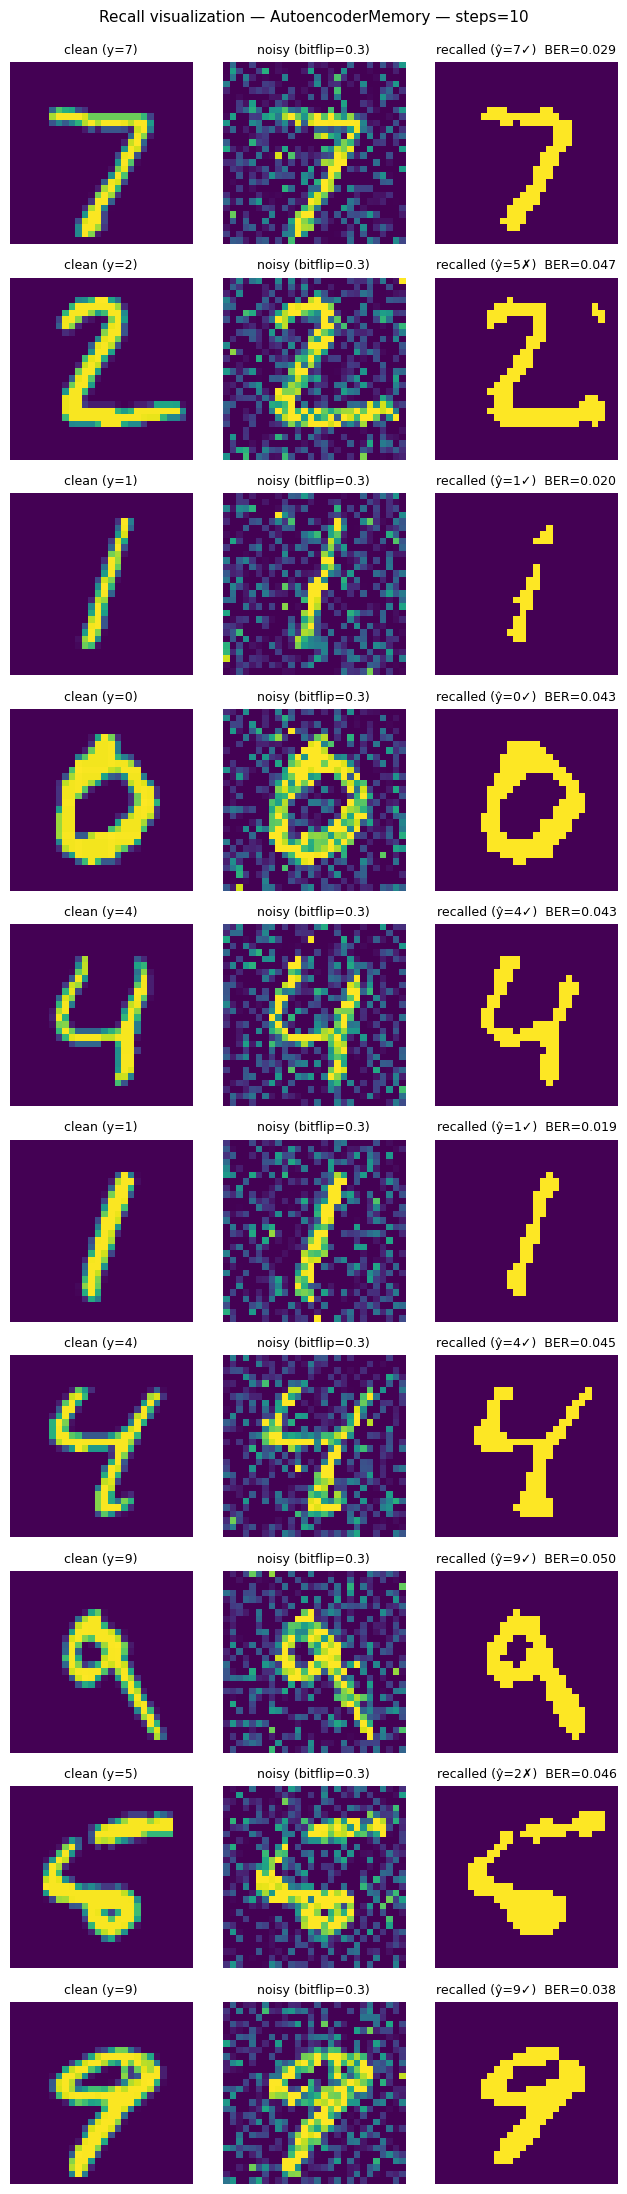

{'x_clean01': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],


In [12]:
# === Recall visualizer (LEFT→RIGHT flow, no extra "cleaning" row by default) ===
import matplotlib.pyplot as plt
import torch

class RecallVisualizer:
    """
    Shows per-sample triptychs laid out LEFT→RIGHT:
        [ clean | noisy | recalled ]   (optionally a 4th 'rec - clean' column)
    Works for both bipolar (Hopfield-style) and continuous (AE/KNN/Latent) memories.

    Example (Hopfield):
        viz = RecallVisualizer(test_loader)
        name, model, mems = [m for m in models if "HopfieldBinary" in m[0]][0]
        viz.show(model, memories=mems, noise_kind="bitflip", noise_level=0.3, steps=10, k=10)
    """
    def __init__(self, test_loader):
        self.test_loader = test_loader

    @torch.no_grad()
    def show(
        self,
        model: BaseAssocMemory,
        memories: Optional[torch.Tensor] = None,
        noise_kind: str = "bitflip",             # "bitflip" | "gaussian" | "saltpepper" | "occlusion"
        noise_level: float = 0.3,
        steps: int = 10,
        k: int = 8,                              # number of examples (rows)
        cont_fallback_for_bitflip: str = "gaussian",  # for non-bipolar models when 'bitflip' requested
        seed: Optional[int] = None,
        show_diffs: bool = False,                # add a 4th column with signed diff (rec - clean)
    ):
        model.eval()
        if memories is not None:
            model.store(memories)

        # sample a mini-batch
        x, y = next(iter(self.test_loader))             # x in [0,1], (B,1,28,28)
        if seed is not None:
            g = torch.Generator().manual_seed(seed)
            idx = torch.randperm(x.size(0), generator=g)[:k]
        else:
            idx = torch.arange(min(k, x.size(0)))
        x = x[idx].to(DEVICE)
        y = y[idx]

        # prepare noise & recall per model type
        if model.expects_bipolar:
            x_clean_bip = to_flat(to_bipolar01(x))      # (k, D)
            if noise_kind == "bitflip":
                x_in_bip = bitflip_noise_bipolar(x_clean_bip, flip_prob=noise_level)
                x_noisy01 = from_bipolar01(x_in_bip).view(-1, 1, 28, 28)  # for display
            else:
                x_noisy01 = apply_noise(x, kind=noise_kind, level=noise_level)
                x_in_bip = to_flat(to_bipolar01(x_noisy01))
            x_rec_bip = model.recall(x_in_bip, steps=steps)                # (k, D) in {-1,+1}
        else:
            # continuous models: when 'bitflip' requested, map to continuous fallback (no hard bit flips)
            cont_kind = cont_fallback_for_bitflip if noise_kind == "bitflip" else noise_kind
            x_noisy01 = apply_noise(x, kind=cont_kind, level=noise_level)
            x_rec_bip = model.recall(to_flat(x_noisy01), steps=steps)

        # tensors for plotting
        x_clean01 = x.detach().cpu()
        x_noisy01 = x_noisy01.detach().cpu()
        x_rec01   = from_bipolar01(x_rec_bip).view(-1, 1, 28, 28).detach().cpu()

        # predictions & bit-error rates
        y_hat = predict_class_from_bipolar(x_rec_bip).cpu()
        x_true_bip = to_flat(to_bipolar01(x.to(DEVICE))).cpu()
        ber = (x_rec_bip.cpu() != x_true_bip).float().mean(dim=1)  # per-sample

        # --- L→R layout: rows = samples, cols = [clean | noisy | recalled | (optional diff)] ---
        cols = 3 + int(show_diffs)
        fig, axes = plt.subplots(k, cols, figsize=(2.2*cols, 2.2*k))
        if k == 1:
            axes = axes.reshape(1, cols)

        for i in range(k):
            # col 0: clean
            axes[i, 0].imshow(x_clean01[i, 0], vmin=0, vmax=1)
            axes[i, 0].set_title(f"clean (y={y[i].item()})", fontsize=9)
            axes[i, 0].axis("off")

            # col 1: noisy
            axes[i, 1].imshow(x_noisy01[i, 0], vmin=0, vmax=1)
            axes[i, 1].set_title(f"noisy ({noise_kind}={noise_level})", fontsize=9)
            axes[i, 1].axis("off")

            # col 2: recalled
            ok = "✓" if y_hat[i].item() == y[i].item() else "✗"
            axes[i, 2].imshow(x_rec01[i, 0], vmin=0, vmax=1)
            axes[i, 2].set_title(f"recalled (ŷ={y_hat[i].item()}{ok})  BER={ber[i].item():.3f}", fontsize=9)
            axes[i, 2].axis("off")

            # optional col 3: signed difference (for diagnostics, off by default)
            if show_diffs:
                diff = (x_rec01[i, 0] - x_clean01[i, 0])  # in [-1,1]
                im = axes[i, 3].imshow(diff, vmin=-1, vmax=1, cmap="coolwarm")
                axes[i, 3].set_title("rec - clean", fontsize=9)
                axes[i, 3].axis("off")

        plt.suptitle(f"Recall visualization — {model.__class__.__name__} — steps={steps}", y=0.995, fontsize=11)
        plt.tight_layout()
        plt.show()

        return {
            "x_clean01": x_clean01, "x_noisy01": x_noisy01, "x_recalled01": x_rec01,
            "y": y.cpu(), "y_hat": y_hat, "bit_error_rate": ber.cpu()
        }

# Example:
viz = RecallVisualizer(test_loader)
name, model, mems = [m for m in models if "AutoencoderMemory" in m[0]][0]
viz.show(model, memories=mems, noise_kind="bitflip", noise_level=0.3, steps=10, k=10)  # L→R flow
